# Simulador do Sistema da Paraíba do Sul: Exploração de Resultados
## Baixe e execute esse notebook para display dos gráficos.

# Importando bibliotecas:

In [55]:
using DataFrames, CSV, Dates, Measures, Statistics, StatsPlots
gr()

Plots.GRBackend()

## Executa simulação e gera resultados do caso exemplo:

In [56]:
dir = "example"
include("./src/SimulatorParaibaDoSul.jl")
SPS = SimulatorParaibaDoSul
SPS.run_simulation(dir)

########### Simulation Start ###########


Simulation progress: 0.09363295880149813%
Simulation progress: 0.18726591760299627%
Simulation progress: 0.2808988764044944%
Simulation progress: 0.37453183520599254%
Simulation progress: 0.4681647940074906%
Simulation progress: 0.5617977528089888%
Simulation progress: 0.6554307116104869%
Simulation progress: 0.7490636704119851%
Simulation progress: 0.8426966292134831%
Simulation progress: 0.9363295880149812%
Simulation progress: 1.0299625468164795%
Simulation progress: 1.1235955056179776%
Simulation progress: 1.2172284644194757%
Simulation progress: 1.3108614232209739%
Simulation progress: 1.404494382022472%
Simulation progress: 1.4981273408239701%
Simulation progress: 1.591760299625468%
Simulation progress: 1.6853932584269662%
Simulation progress: 1.7790262172284643%
Simulation progress: 1.8726591760299625%
Simulation progress: 1.9662921348314606%
Simulation progress: 2.059925093632959%
Simulation progress: 2.153558052434457%
Simulation progress: 2.247191011235955%
Simulation progre

"Simulation complete, results available at: example/results"

## Lê resultados:

In [82]:
df_generation = DataFrame(CSV.File(joinpath(dir,"results",dir*"_generation_MW.csv")))
df_turbining = DataFrame(CSV.File(joinpath(dir,"results",dir*"_turbining_m3_per_sec.csv")))
df_spillage = DataFrame(CSV.File(joinpath(dir,"results",dir*"_spillage_m3_per_sec.csv")))
df_reservoir = DataFrame(CSV.File(joinpath(dir,"results",dir*"_reservoir_Hm3.csv")))
first(df_generation, 5)

,step,month,stage,ps_equivalent_reservoir,paraibuna,simplicio,sta_branca
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,1,0.946673,8.22244,265.262,10.5441
2,2,2,1,0.998262,87.9353,265.262,49.5346
3,3,3,1,1.0,87.9353,265.262,49.7538
4,4,4,1,1.0,60.1794,265.262,29.4887
5,5,5,1,1.0,44.9263,255.219,26.4925


## Apresenta reservatório equivalente ao longo do tempo, e respectivos estágios de deplecionamento.

### A correlação entre o valor do reservatório equivalente e os estágios de deplecionamento se torna clara. Períodos de alta ou baixa de água são visíveis e na maioria das vezes periódicos.

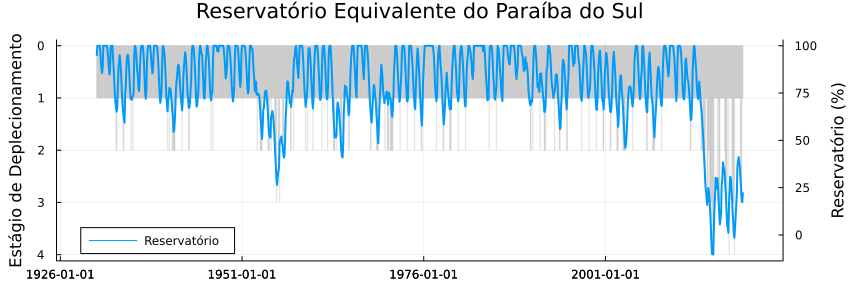

In [58]:
time = Date(1931):Month(1):Date(1931)+Month(size(df_generation,1)-1)
eq_reservoir = df_generation[:,"ps_equivalent_reservoir"]
stages = df_generation[:,"stage"]

bar(time,stages,
    ylabel = "Estágio de Deplecionamento",
    color = "grey",
    alpha = 0.08,
    legend = false,
    size = (900,300),
    title = "Reservatório Equivalente do Paraíba do Sul",
    margin=5mm,
    right_margin = 15mm,
    yflip = true
)


p = plot!(twinx(),time,eq_reservoir*100,
    label = "Reservatório",
    ylabel = "Reservatório (%)",
    lw = 2,
    margin=5mm,
    size = (850,300),
    legend = :bottomleft
)

savefig("figures//figure_1.png")
p

## Apresenta distribuição de Vertimento e Turbinamento de Santa Cecília:

### Valores de interesse, como vertimento e turbinamento mínimo, ganham destaque no resultado, como era de se esperar pelas suas regras operativas. 

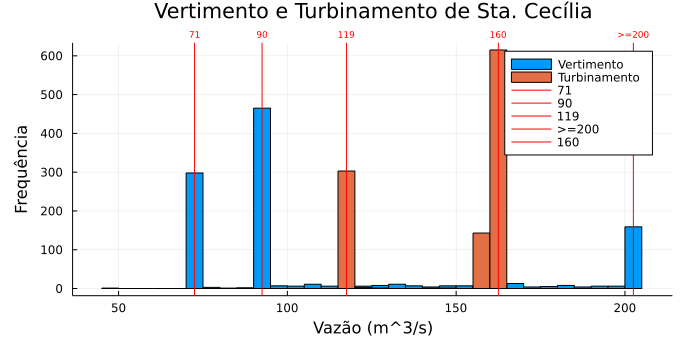

In [59]:
sta_cecilia_spillage = df_spillage[:,"sta_cecilia"]
sta_cecilia_turbining = df_turbining[:,"sta_cecilia"]

df_sta_cecilia = DataFrame(Dict(
    "Turbining m^{3}/s" => sta_cecilia_turbining,
    "Spillage m^{3}/s" => sta_cecilia_spillage,
))

sta_cecilia_spillage = [spill < 200 ? spill : 200 for spill in sta_cecilia_spillage]

histogram(sta_cecilia_spillage,
    bins = 30,
    label = "Vertimento",
    title = "Vertimento e Turbinamento de Sta. Cecília",
    xlabel = "Vazão (m^3/s)",
    ylabel = "Frequência",
    size = (700,350),
    margin = 5mm
)
histogram!(sta_cecilia_turbining,
    bins = 25,
    label = "Turbinamento"
)

plot!([70+2.5], seriestype="vline",color=:red,label = "71")
annotate!(70+2.5, 655, text(string(71), :red, 6))

plot!([90+2.5], seriestype="vline",color=:red,label="90")
annotate!(90+2.5, 655, text(string(90), :red, 6))

plot!([115+2.5], seriestype="vline",color=:red,label="119")
annotate!(115+2.5, 655, text(string(119), :red, 6))

plot!([200+2.5], seriestype="vline",color=:red,label=">=200")
annotate!(200+2.5, 655, text(">=200", :red, 6))

p = plot!([160+2.5], seriestype="vline",color=:red,label="160")
annotate!(160+2.5, 655, text(string(160), :red, 6))

savefig("figures//figure_2.png")
p

## Apresenta geração média do simulador vs SUISHI:

### Pode ser visto que os valores são bem próximos.

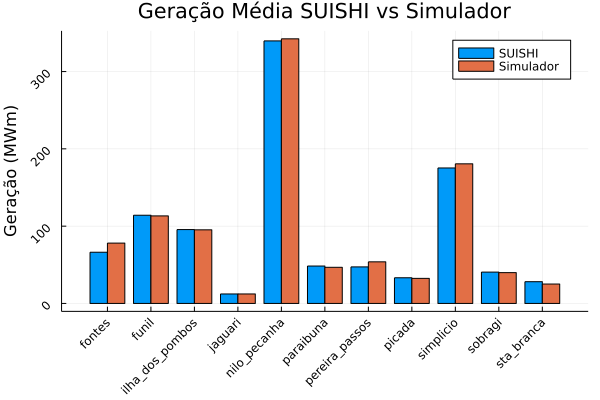

In [60]:
df_generation[:,"fontes"] = df_generation[:,"fontes_a"] + df_generation[:,"fontes_bc"]
labels = [
    "paraibuna",
    "simplicio",
    "sta_branca",
    "jaguari",
    "ilha_dos_pombos",
    "funil",
    "sobragi",
    "fontes",
    "nilo_pecanha",
    "picada",
    "pereira_passos"
]
simulator_means = mean.(eachcol(df_generation[:,labels]))
suishi_means = [48.425, 175.28, 28.154, 12.288, 95.542, 114.145, 40.571, 66.286, 339.645, 33.178, 47.305]
df_suishi_means = DataFrame(Dict(labels[i] => suishi_means[i] for i in 1:length(suishi_means)))
p = StatsPlots.groupedbar(repeat(labels,outer=2),[simulator_means suishi_means],
    rotation = 45,
    title = "Geração Média SUISHI vs Simulador",
    ylabel = "Geração (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulador", "SUISHI"], inner = 11)
)

savefig("figures//figure_3.png")
p

## Apresenta geração média do simulador vs SUISHI agrupados pelas plantas da Light ou todas:

Geração Média Total SUISHI: 1000.819
Geração Média Total Simulador: 1019.8378866978734
Geração Média Light SUISHI: 797.807
Geração Média Light SUISHI: 822.4983050642435


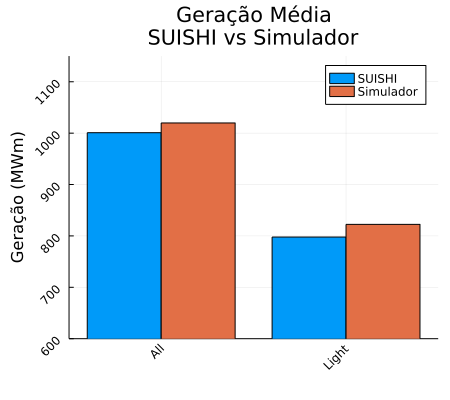

In [61]:
light = ["simplicio","ilha_dos_pombos","sobragi","fontes","nilo_pecanha","picada","pereira_passos"]
total_means = [sum(simulator_means); sum(suishi_means)]
light_means = [sum(mean.(eachcol(df_generation[:,light]))); sum(df_suishi_means[1,light])]
p = StatsPlots.groupedbar(repeat(["All","Light"],outer=2),[total_means light_means]',
    rotation = 45,
    title = "Geração Média\nSUISHI vs Simulador",
    ylabel = "Geração (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulador", "SUISHI"], inner = 2),
    ylim = (600,1150),
    size = (450,400)
)
println("Geração Média Total SUISHI: $(sum(suishi_means))")
println("Geração Média Total Simulador: $(sum(simulator_means))")
println("Geração Média Light SUISHI: $(sum(df_suishi_means[1,light]))")
println("Geração Média Light Simulador: $(sum(mean.(eachcol(df_generation[:,light]))))")
savefig("figures//figure_4.png")
p

## Apresenta geração média do simulador no período crítico vs no período completo:

### Como esperado, valores no período crítico são ligeiramente menores do que o normal.

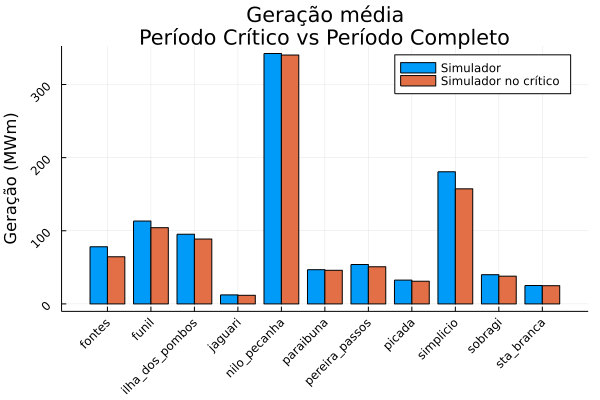

In [62]:
df_critical = df_generation[222:311,labels]

simulator_means = mean.(eachcol(df_generation[:,labels]))
critical_means = mean.(eachcol(df_critical))

p =StatsPlots.groupedbar(repeat(labels,outer=2),[simulator_means critical_means],
    rotation = 45,
    title = "Geração média\nPeríodo Crítico vs Período Completo",
    ylabel = "Geração (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulador", "Simulador no crítico"], inner = 11)
)

savefig("figures//figure_5.png")
p

## Apresenta geração média durante período crítico do simulador vs SUISHI agrupados pelas plantas da Light ou todas:

Geração Média Total SUISHI: 936.5749999999999
Geração Média Total Simulador: 956.8976763450787
Geração Média Light SUISHI: 750.2719999999999
Geração Média Light Simulador: 770.2145044057264


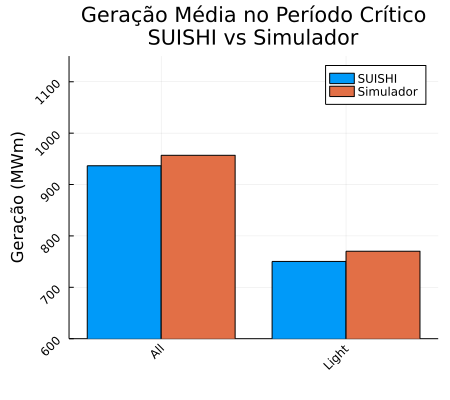

In [64]:
simulator_means = mean.(eachcol(df_critical[:,labels]))
suishi_means = [45.927, 152.505, 26.901, 11.239, 87.228,102.236,38.5,32.8+23.964,337.717,31.641,45.917]
df_suishi_means = DataFrame(Dict(labels[i] => suishi_means[i] for i in 1:length(suishi_means)))
total_means = [sum(simulator_means); sum(suishi_means)]
light_means = [sum(mean.(eachcol(df_critical[:,light]))); sum(df_suishi_means[1,light])]
p = StatsPlots.groupedbar(repeat(["All","Light"],outer=2),[total_means light_means]',
    rotation = 45,
    title = "Geração Média no Período Crítico\nSUISHI vs Simulador",
    ylabel = "Geração (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulador", "SUISHI"], inner = 2),
    ylim = (600,1150),
    size = (450,400)
)

println("Geração Média Total SUISHI: $(sum(suishi_means))")
println("Geração Média Total Simulador: $(sum(simulator_means))")
println("Geração Média Light SUISHI: $(sum(df_suishi_means[1,light]))")
println("Geração Média Light Simulador: $(sum(mean.(eachcol(df_critical[:,light]))))")

savefig("figures//figure_6.png")
p

## Indicadores:

In [69]:
labels = [
    "paraibuna",
    "simplicio",
    "sta_branca",
    "jaguari",
    "ilha_dos_pombos",
    "funil",
    "sobragi",
    "fontes_a",
    "fontes_bc",
    "nilo_pecanha",
    "picada",
    "pereira_passos"
]
df_spillage_values = df_spillage[:,labels]
df_turbining_values = df_turbining[:,labels]
total_spillage = sum(sum.(eachcol(df_spillage_values)))
total_turbining = sum(sum.(eachcol(df_turbining_values)))
total_defluence = total_spillage + total_turbining
println("Parcela de Vertimento Total (Vertimento/Afluência): $(total_spillage/total_defluence)")
println("Parcela de Turbinamento Total (Turbinamento/Afluência): $(total_turbining/total_defluence)")
println("Média do Reservatório Equivalente da Paraíba do Sul: $(mean(eq_reservoir))")

Parcela de Vertimento Total (Vertimento/Afluência): 0.16442228831080258
Parcela de Turbinamento Total (Turbinamento/Afluência): 0.8355777116891974
Média do Reservatório Equivalente da Paraíba do Sul: 0.7938442302968599


In [123]:
file_path = joinpath(dir,"hidroplants_params.csv")
df_params = DataFrame(CSV.File(file_path))
paraiba = [
    "paraibuna",
    "sta_branca",
    "jaguari",
    "funil"
]
df_reservoir_values = df_reservoir[:,paraiba]
df_spillage_violations = copy(df_spillage_values)
df_turbining_violations = copy(df_turbining_values)
df_reservoir_violations = copy(df_reservoir_values)
for name in names(df_turbining_violations)
    min_spillage = filter(r -> r["name"] == name,df_params)[!,"min_spillage"][1]
    min_turbining = filter(r -> r["name"] == name,df_params)[!,"min_turbining"][1]
    min_reservoir = filter(r -> r["name"] == name,df_params)[!,"min_reservoir"][1]
    for i in 1:size(df_spillage_violations[:,name],1)
        df_spillage_violations[i,name] = df_spillage_violations[i,name] < min_spillage ? df_spillage_violations[i,name]/min_spillage : 0
        df_turbining_violations[i,name] = df_turbining_violations[i,name] < min_turbining ? df_turbining_violations[i,name]/min_turbining : 0
        if name in paraiba
            df_reservoir_violations[i,name] = df_reservoir_violations[i,name] < min_reservoir ? df_reservoir_violations[i,name]/min_reservoir : 0
        end
    end
end
function mean_not_zero(v)
    count = 0
    sum = 0
    for i in v
        if i != 0
            count += 1
            sum += i
        end
    end
    return sum/count
end
atv = mean([mean for mean in mean_not_zero.(eachcol(df_turbining_violations)) if !isnan(mean)])
arv = mean([mean for mean in mean_not_zero.(eachcol(df_reservoir_violations)) if !isnan(mean)])

println("Média de violação relativa de turbinamento mínimo (violação/mínimo): $(atv)")
println("Média de violação relativa de reservatório mínimo em Paraíba do Sul (violação/mínimo): $(arv)")

Média de violação relativa de turbinamento mínimo (violação/mínimo): 0.8405425413521244
Média de violação relativa de reservatório mínimo em Paraíba do Sul (violação/mínimo): 0.8846572320711363
